In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [2]:
# Loading the Dataset
df = pd.read_csv("Employe_Performance_dataset.csv")

In [3]:
# Previewing the dataset
df.head()

,ID,Name,Age,Gender,Department,Salary,Joining Date,Performance Score,Experience,Status,Location,Session
0,1,Cory Escobar,48,Female,HR,5641,2015-05-03,2.0,16,Active,New York,Night
1,2,Timothy Sanchez,25,Other,Sales,4249,2020-11-09,2.0,11,Inactive,Los Angeles,Evening
2,3,Chad Nichols,57,Other,Sales,3058,2019-02-12,NaN,1,Inactive,New York,Morning
3,4,Christine Williams,58,Female,IT,5895,2017-09-08,2.0,13,Inactive,Los Angeles,Evening
4,5,Amber Harris,35,Other,IT,4317,2020-02-15,5.0,16,Inactive,New York,Evening


In [4]:
# Checking the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1000 non-null   int64  
 1   Name               1000 non-null   object 
 2   Age                1000 non-null   int64  
 3   Gender             1000 non-null   object 
 4   Department         1000 non-null   object 
 5   Salary             1000 non-null   int64  
 6   Joining Date       1000 non-null   object 
 7   Performance Score  502 non-null    float64
 8   Experience         1000 non-null   int64  
 9   Status             1000 non-null   object 
 10  Location           1000 non-null   object 
 11  Session            1000 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 93.9+ KB


In [5]:
# Checking for missing variables
df.isnull().sum()

ID                     0
Name                   0
Age                    0
Gender                 0
Department             0
Salary                 0
Joining Date           0
Performance Score    498
Experience             0
Status                 0
Location               0
Session                0
dtype: int64

In [6]:
# Data Cleaning
# Dropping rows with missing Performance Score
df = df.dropna(subset=['Performance Score'])


In [7]:
# Convert Joining Date to datetime
df['Joining Date'] = pd.to_datetime(df['Joining Date'], errors='coerce')
df['Tenure (Years)'] = (pd.Timestamp("now") - df['Joining Date']).dt.days // 365

In [8]:
# Drop irrelevant columns
df = df.drop(columns=['Name', 'ID'], errors='ignore')

In [9]:
#  Target Mapping
# Map Performance Score to categories
def map_score(score):
    if score <= 2:
        return 'Low'
    elif score == 3:
        return 'Average'
    else:
        return 'High'

df['Performance Category'] = df['Performance Score'].apply(map_score)

# Drop original score
df = df.drop(columns=['Performance Score'])

In [10]:
# Encode Categorical Features
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Unknown')
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [11]:
# Splitting into dependent and independent variable
# 6. Feature/Target Split
df = df.drop(columns=['Joining Date'], errors='ignore')
X = df.drop(columns=['Performance Category'])
y = df['Performance Category']

In [12]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# 9. Model Training and Comparison
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {'Accuracy': acc, 'F1 Score': f1}
    
    print(f"\n{name} Results:")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Random Forest Results:
Accuracy: 0.49504950495049505
F1 Score: 0.4836313397757777
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.25      0.31        16
           1       0.46      0.41      0.43        39
           2       0.54      0.65      0.59        46

    accuracy                           0.50       101
   macro avg       0.46      0.44      0.44       101
weighted avg       0.48      0.50      0.48       101

Confusion Matrix:
 [[ 4  7  5]
 [ 2 16 21]
 [ 4 12 30]]

Logistic Regression Results:
Accuracy: 0.44554455445544555
F1 Score: 0.3999784707899997
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.44      0.36      0.39        39
           2       0.46      0.67      0.54        46

    accuracy                           0.45       101
   macro avg       0.30      0.34      0.31       101
weighted avg     

In [15]:
# Compare and Select Best Model
results_df = pd.DataFrame(results).T.sort_values(by="F1 Score", ascending=False)
print("\n🔍 Model Comparison:\n")
print(results_df)

# Select best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]

print(f"\n✅ Best model selected: {best_model_name}")



🔍 Model Comparison:

                     Accuracy  F1 Score
XGBoost              0.504950  0.505491
Random Forest        0.495050  0.483631
Logistic Regression  0.445545  0.399978

✅ Best model selected: XGBoost



📌 Final Evaluation with Best Model:
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.31      0.29        16
           1       0.53      0.46      0.49        39
           2       0.57      0.61      0.59        46

    accuracy                           0.50       101
   macro avg       0.46      0.46      0.46       101
weighted avg       0.51      0.50      0.51       101

Confusion Matrix:
 [[ 5  5  6]
 [ 6 18 15]
 [ 7 11 28]]


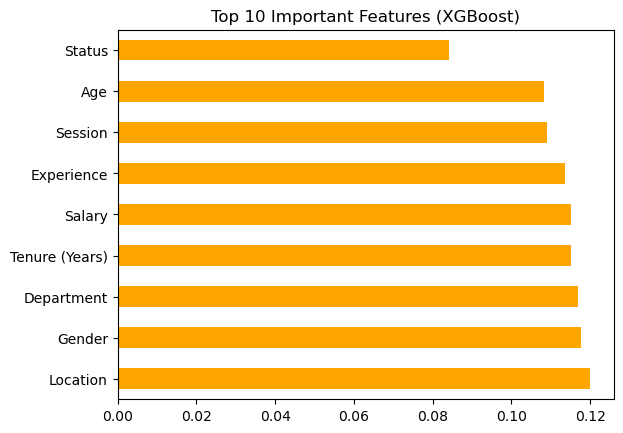

In [16]:
# Final Evaluation with Best Model
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

print("\n📌 Final Evaluation with Best Model:")
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

# 12. Feature Importance
if best_model_name == 'Random Forest':
    feat_imp = pd.Series(best_model.feature_importances_, index=X.columns)
    feat_imp.nlargest(10).plot(kind='barh')
    plt.title("Top 10 Important Features (Random Forest)")
    plt.show()
elif best_model_name == 'XGBoost':
    feat_imp = pd.Series(best_model.feature_importances_, index=X.columns)
    feat_imp.nlargest(10).plot(kind='barh', color='orange')
    plt.title("Top 10 Important Features (XGBoost)")
    plt.show()